# Sneaker Finder development notebook

### version 0.1 Jan 2020
### version 0.2 Feb 2020
### version 0.3 June 2020
### version 1.0 Dec 2020 (refactor using pytorch/nbdev/fastai framework)

# OVERVIEW

This is a project initiated while an Insight Data Science fellow.  It grew out of thinking about how to make data-driven tools that could impact the fashion industry which I had been working working in.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some sneaker designs based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

This is a cool reference for a fastai VAE
https://medium.com/@dhuynh95/an-introduction-to-unsupervised-learning-with-fastai-a6dbd78eca2b


In [1]:
#hide
from fastbook import *
from fastai.vision.all import *

First we need to get a database of sneaker images.   The sneaker images are only 136 pixels wide, and organized by 'Category', 'SubCategory', and 'Brand'.   Additional semantic information is also available from Mechanical Turk labeling, and is available packed into matlab files.  

In [2]:
DB_path = Path.home()/'Projects/DATABASE'
DB_path

Path('/home/ergonyc/Projects/DATABASE')

# Part 0: DATA

## Part 1: import the UT-Zappos50k database

untar_data

In [3]:
# don't use the "square" versions because they are excessively padded.  we'll simply pad with "white"
#url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip"
url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip"
# the images are wider than tall with the product already taking up aproximately the whole vertical dimension
url_meta = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-data.zip"

DATA_path = Path.home()/'Projects/DATABASE'

path_meta = untar_data(url_meta, dest=DATA_path)
path_images = untar_data(url_images,dest=DATA_path)

## data set cleaning

The dataset is very diverse and not constructed in order to think about how popular footwear is aesthetically related.  I'm simplifying the database to include 4 categories which seem to split aesthetics for general footwear:

1) BOOTS - weatherized and/or protected footwear for work or outdoor activity
2) SANDALS - charachterized by a sole and straps
3) SHOES - generic non "boot" footwear.  includes heels and formalwear
4) SNEAKERS - atheletic / comfort inspired 

In [4]:
import scipy.io as sio

def path_from_mat(fname):
    """ reads zappos imagepath from matlab file"""
    data = sio.loadmat(fname)['imagepath']
    return [i[0][0] for i in data]

image_path = path_from_mat(path_meta/'image-path.mat')
df = pd.read_csv(path_meta/'meta-data.csv')

df["path"]=image_path

In [5]:
# ad sub-categories (one-hot)
categories=pd.read_csv(path_meta/'meta-data-bin.csv')
df = pd.merge(df, categories,  how='left', on='CID')# left_on=['CID'], right_on = ['CID'])

df.head()

,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle,path,Category.Shoes,Category.Boots,Category.Sandals,Category.Slippers,SubCategory.Oxfords,SubCategory.Mid.Calf,SubCategory.Heel,SubCategory.Ankle,SubCategory.Boot,SubCategory.Loafers,SubCategory.Slipper.Flats,SubCategory.Boat.Shoes,SubCategory.Flat,SubCategory.Clogs.and.Mules,SubCategory.Flats,SubCategory.Sneakers.and.Athletic.Shoes,SubCategory.Slipper.Heels,SubCategory.Heels,SubCategory.Athletic,SubCategory.Prewalker,SubCategory.Knee.High,SubCategory.Prewalker.Boots,SubCategory.Crib.Shoes,SubCategory.Firstwalker,SubCategory.Over.the.Knee,HeelHeight.1in...1.3.4in,HeelHeight.2in...2.3.4in,HeelHeight.Under.1in,HeelHeight.Flat,HeelHeight.4in...4.3.4in,HeelHeight.3in...3.3.4in,HeelHeight.5in...over,Insole.Leather,Insole.Padded,Insole.Removable,Insole.Moisture.Wicking,Insole.Poron,Insole.EVA,Insole.Textile,Insole.Orthotic.Friendly,Insole.Memory.Foam,Insole.Polyurethane,Insole.Latex.Lined,Insole.Synthetic.Leather,Insole.Hypoallergenic,Insole.Gel,Closure.Lace.up,Closure.Pull.on,Closure.Buckle,Closure.Ankle.Strap,Closure.Hook.and.Loop,Closure.Zipper,Closure.Slip.On,Closure.Elastic.Gore,Closure.Ankle.Wrap,Closure.Sling.Back,Closure.Bungee,Closure.Toggle,Closure.Adjustable,Closure.Snap,Closure.Button.Loop,Closure.T.Strap,Closure.Monk.Strap,Closure.Spat.Strap,Closure.Belt,Gender.Men,Gender.Women,Gender.Boys,Gender.Girls,Material.Leather,Material.Rubber,Material.Nappa,Material.Neoprene,Material.Suede,Material.Canvas,Material.Ostrich,Material.Polyurethane,Material.Cotton,Material.Nubuck,Material.Sheepskin,Material.Hair.Calf,Material.Full.grain.leather,Material.Synthetic,Material.Deerskin,Material.Faux.Leather,Material.Distressed.Leather,Material.Nylon,Material.Terry,Material.Mesh,Material.Patent.Leather,Material.EVA,Material.Fleece,Material.Microfiber,Material.Jute,Material.Cork,Material.Shearling,Material.Wool,Material.Felt,Material.Vinyl,Material.Satin,Material.Latex,Material.Acrylic,Material.Cordura,Material.Snakeskin,Material.Cashmere,Material.Denim,Material.Lizard,Material.Silk,Material.Lace,Material.Faux.Fur,Material.Corduroy,Material.Lambskin,Material.Tweed,Material.Velvet,Material.Polyester,Material.Hemp,Material.Aluminum,Material.Jacquard,Material.Crocodile,Material.Velour,Material.Faux.Suede,Material.Ripstop,Material.Linen,Material.Cable.Knit,Material.Crochet,Material.Raffia,Material.Steel,Material.Chiffon,Material.Horse.Hair,Material.Exotic,Material.Plastic,Material.Stingray,ToeStyle.Capped Toe,ToeStyle.Round Toe,ToeStyle.Square Toe,ToeStyle.Closed Toe,ToeStyle.Snub Toe,ToeStyle.Moc Toe,ToeStyle.Bicycle Toe,ToeStyle.Wingtip,ToeStyle.Open Toe,ToeStyle.Center Seam,ToeStyle.Pointed Toe,ToeStyle.Algonquin,ToeStyle.Almond,ToeStyle.Bump Toe,ToeStyle.Apron Toe,ToeStyle.Wide Toe Box,ToeStyle.Snip Toe,ToeStyle.Peep Toe,ToeStyle.Medallion
0,100627-72,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100627.72.jpg,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100627-255,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100627.255.jpg,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100657-72,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe,Shoes/Oxfords/Bostonian/100657.72.jpg,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [6]:
# fix the path by remove trailing periods in folder names
df.loc[df.path.str.contains("./",regex=False),"path"] = [i.replace("./","/") for i in df.loc[df.path.str.contains("./",regex=False),"path"]]
df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"] = [i.replace("Levi\'s ","Levis ") for i in df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"]]

In [7]:
# create brands and category stubs...
df['path_and_file'] = df.path.apply(lambda path: (os.path.normpath(path)).split(os.sep) ) 
df_to_add = pd.DataFrame(df['path_and_file'].tolist(), columns=['Category1','Category2','Brand','Filename'])

df = pd.merge(df, df_to_add, left_index=True, right_index=True)

In [8]:
# df.loc[df.path.str.contains("\'",regex=False),"path"]

assert (df['Category'] == df['Category1']).all()
assert (df['SubCategory'] == df['Category2']).all()


In [9]:
df.Gender.value_counts()

Women                   26949
Men                     12107
Girls                    5233
Boys                     3187
Boys;Girls               1304
Men;Women                1226
Women;Girls                 9
Men;Boys;Women;Girls        4
Name: Gender, dtype: int64

## simplify:

Categories:
    - SHOES, 
    - BOOTS, 
    - "SNEAKERS", and 
    - "SLIPPERS"

Only include "adult" shoes
    - Adult (kids = not-Adult)
    - mens womens (kids = not adults), etc (unisex)

To construct these from the Zappos I needed to pull sneakers from shoes and exclude some sub-categories.  e.g. tall boots which would drive the representation of boots.

    BOOTS:
      BOOTS
        - ankle,  mid-calf
        - exclude: knee high , over the knee , prewalker

    SANDALS:
      SANDALS
        - athletic, flat
        - exclude: heels 
        
    SHOES:
      SHOES
        - Boat shoes, clogs and mules,  flats,  loafers, oxfords, prewalker
        - exclude: heels , crib shoes , firstwalker (exclude)

    SNEAKERS
       SHOES
       - sneakers and athletic shoes

     SLIPPERS (exclude)

In [10]:
# add our "sneaker category"
df.loc[:,'Sneakers'] = (df['Category2'] == 'Sneakers and Athletic Shoes')

# refine boot
df.loc[:,'Boots'] = (  (df.Category1 == 'Boots') 
                     & (df.Category2 != 'Knee High')
                     & (df.Category2 != 'Over the Knee')
                     & (df.Category2 != 'Prewalker Boots') )

# refine shoes
df.loc[:,'Shoes'] = (  (df.Category1 == 'Shoes') 
                     & (df.Category2 != 'Sneakers and Athletic Shoes')
                     & (df.Category2 != 'Crib Shoes')
                     & (df.Category2 != 'Firstwalker')
                     & (df.Category2 != 'Prewalker') )

# refine shoes
df.loc[:,'Slippers'] = (  (df.Category1 == 'Shoes') 
                     & (df.Category2 != 'Sneakers and Athletic Shoes')
                     & (df.Category2 != 'Crib Shoes')
                     & (df.Category2 != 'Firstwalker')
                     & (df.Category2 != 'Prewalker') )

# define Slippers 
df.loc[:,'Slippers'] = (df.Category1 == 'Slippers')
                

In [11]:
############
#remove ([ 'Boys',  'Boys;Girls', 'Girls','Women;Girls', nan

df['Gender'].str.contains('Men', na=False)

0         True
1         True
2         True
3         True
4         True
         ...  
50020    False
50021    False
50022    False
50023    False
50024     True
Name: Gender, Length: 50025, dtype: bool

In [12]:
mens =  df['Gender'] == 'Men'       
womens =  df['Gender'] == 'Women' 
etc =  df['Gender'].str.contains('Men;', na=False)

df.loc[:,'Adult'] = mens | womens | etc

df.loc[:,'Mens'] = mens 
df.loc[:,'Womens'] = womens

df.loc[:,'OGcategory'] = df.Category
df.loc[:,'Category'] = pd.NA

df.loc[(df.Shoes==1),'Category'] = 'Shoes'
df.loc[(df.Boots==1),'Category'] = 'Boots'
df.loc[(df.Sneakers==1),'Category'] = 'Sneakers'
df.loc[(df.Slippers==1),'Category'] = 'Slippers'


In [13]:
# make some expository columns 
keep_columns = ['CID','Category',
                 'CategoryDir', 'NewCategory',
                 'path','Category.Shoes',
                 'Category.Boots','Category.Sandals',
                 'Category.Slippers','SubCategory.Sneakers.and.Athletic.Shoes',
                 'Gender.Men','Gender.Women',
                 'Gender.Boys','Gender.Girls',
                 'Sneaker', 'path_and_file',
                 'Category1', 'Category2',
                 'Brand','Filename',
                 'Sneakers','Boots',
                 'Shoes', 'Slippers',
                 'Gender','Adult',
                 'Unisex','Kids',
                 'Mens', 'Womens',
                 'Feminine','Masculine']

df = df.filter(items=keep_columns)
df.tail()

,CID,Category,path,Category.Shoes,Category.Boots,Category.Sandals,Category.Slippers,SubCategory.Sneakers.and.Athletic.Shoes,Gender.Men,Gender.Women,Gender.Boys,Gender.Girls,path_and_file,Category1,Category2,Brand,Filename,Sneakers,Boots,Shoes,Slippers,Gender,Adult,Mens,Womens
50020,8168300-128,Shoes,Shoes/Heels/J. Renee/8168300.128.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.128.jpg]",Shoes,Heels,J. Renee,8168300.128.jpg,False,False,True,False,Women,True,False,True
50021,8168300-742,Shoes,Shoes/Heels/J. Renee/8168300.742.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.742.jpg]",Shoes,Heels,J. Renee,8168300.742.jpg,False,False,True,False,Women,True,False,True
50022,8168300-57113,Shoes,Shoes/Heels/J. Renee/8168300.57113.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.57113.jpg]",Shoes,Heels,J. Renee,8168300.57113.jpg,False,False,True,False,Women,True,False,True
50023,8168300-384413,Shoes,Shoes/Heels/J. Renee/8168300.384413.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.384413.jpg]",Shoes,Heels,J. Renee,8168300.384413.jpg,False,False,True,False,Women,True,False,True
50024,8169712-2557,Sneakers,Shoes/Sneakers and Athletic Shoes/Travis Mathew/8169712.2557.jpg,1,0,0,0,1,1,0,0,0,"[Shoes, Sneakers and Athletic Shoes, Travis Mathew, 8169712.2557.jpg]",Shoes,Sneakers and Athletic Shoes,Travis Mathew,8169712.2557.jpg,True,False,False,False,Men,True,True,False


In [14]:
# persist?

#Only keep Adult (men+women) and Sneakers, Boots, Shoes

#keep Adult, Sneakers, Boots, Shoes, Slippers
keep_rows = (df.Sneakers | df.Boots | df.Shoes| df.Slippers) & (df.Adult)
df = df[keep_rows.values]

In [15]:
# make sure removed all the kids product
sum(df["Gender.Boys"])+sum(df['Gender.Girls'])

0

# Save the simplified dataframe for further analysis


Also use sklearn `train_test_split` to create category stratified train/test/validate groups.

In [16]:
from sklearn.model_selection import train_test_split
X = df.index
y = df.Category

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test) 


In [17]:
# pack into the dataframe
df.loc[:,'train'] = False
df.loc[:,'test'] = False
df.loc[:,'validate'] = False
df.loc[:,'t_t_v'] = 'train'
df.loc[x_train,'train'] = True
df.loc[x_test,'test'] = True
df.loc[x_val,'validate'] = True
df.loc[x_test,'t_t_v'] = 'test'
df.loc[x_val,'t_t_v'] = 'valid'

In [18]:
# save it
filename = "zappos-50k-simplified"
df.to_csv(f"data/{filename}.csv")
df.to_pickle(f"data/{filename}.pkl")


continued in "02_model.ipynb"

# Extract features wiht MobileNetV2 

In [83]:
filename = "zappos-50k-simplified"
df = pd.read_csv(f"data/{filename}.csv")


In [5]:
df.path

0                                   Shoes/Oxfords/Bostonian/100627.72.jpg
1                                  Shoes/Oxfords/Bostonian/100627.255.jpg
2                                   Shoes/Oxfords/Bostonian/100657.72.jpg
3                                  Shoes/Oxfords/Bostonian/100657.216.jpg
4                                     Boots/Mid-Calf/Durango/101026.3.jpg
                                       ...                               
33224                                Shoes/Heels/J. Renee/8168300.128.jpg
33225                                Shoes/Heels/J. Renee/8168300.742.jpg
33226                              Shoes/Heels/J. Renee/8168300.57113.jpg
33227                             Shoes/Heels/J. Renee/8168300.384413.jpg
33228    Shoes/Sneakers and Athletic Shoes/Travis Mathew/8169712.2557.jpg
Name: path, Length: 33229, dtype: object

In [6]:
# img_tensors = [tensor(Image.open(path_images/o)) for o in df.path]
# len(img_tensors)

In [7]:
# stackeD_img = torch.stack(img_tensors).float()/255
# stackeD_img.shape

# PYTORCH tutorial on transfer learning.. purt torch

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
plt.ion()   # interactive mode

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
# The problem we're going to solve today is to train a model to classify
# **ants** and **bees**. We have about 120 training images each for ants and bees.
# There are 75 validation images for each class. Usually, this is a very
# small dataset to generalize upon, if trained from scratch. Since we
# are using transfer learning, we should be able to generalize reasonably
# well.
#
# This dataset is a very small subset of imagenet.
#
# .. Note ::
#    Download the data from
#    `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
#    and extract it to the current directory.

# Data augmentation and normalization for training
# Just normalization for validation
IMG_SIZE = 144
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
    ]),
}

#data_dir = 'hymenoptera_data'
data_dir = "mona_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [ ]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.
#

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

######################################################################
#

visualize_model(model_ft)

In [ ]:
######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 7)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)

plt.ioff()
plt.show()

# FastAI code below

In [8]:
import torchvision
from torchvision import models

# def _mobilenetv2_split(m:nn.Module): 
#     return (m[0][0][10],m[1])(m:nn.Module): return (m[0][0][10],m[1])

#mobilenet_split = lambda m: (m[0][0][10], m[1])
#arch  = torchvision.models.mobilenet_v2

model_conv  = models.mobilenet_v2(pretrained=True)

#learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)


In [9]:
#learn = cnn_learner(stacked_img, model_conv, metrics=error_rat
df["Unnamed: 0"]

0            0
1            1
2            2
3            3
4            4
         ...  
33224    50020
33225    50021
33226    50022
33227    50023
33228    50024
Name: Unnamed: 0, Length: 33229, dtype: int64

In [63]:
path_images

def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
#def get_feat(r): return r["Unnamed: 0"]
def get_feat(r): return r['path']
#def get_feat(r): return r['CID']

df.shape
split_list = df.index.to_list()

------------

In [40]:
# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                    splitter=RandomSplitter(valid_pct=0.3,seed=42),
#                    get_x=get_x, 
#                    get_y=get_y,
#                    #item_tfms=Resize(224)
#                    #item_tfms = RandomResizedCrop(224,min_scale=0.95)
#                   )
# dls = dblock.dataloaders(df)

doc(DataBlock)

?Image

In [64]:
# put everythign in train, and don't do any augmentation since we are just going 
# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_feat,
                   item_tfms=Resize(160,method='pad', pad_mode='border')
                  )
#                   batch_tfms=tfms)  # border pads white...





In [65]:
dls = dblock.dataloaders(df,bs=64,drop_last=False, num_workers=4)

#Now that I've read

In [67]:
len(dls.valid)
idx1 = dls[0].get_idxs()

In [66]:
vects = []
clss = []
for inputs,classes in dls[0]:
    outs = model_conv(inputs).data.cpu().numpy()
    vects.extend(list(outs))
    clss.extend(list(classes.data.cpu().numpy()))
        

In [79]:
paths = [dls[0].vocab[i] for i in clss]

In [82]:
#store all relevant info in a pandas datafram 
df_feat = pd.DataFrame({"path": paths, "classes":clss, "feats":vects})
df_feat.head()

,path,classes,feats
0,Shoes/Sneakers and Athletic Shoes/Keds/7397747.3.jpg,25419,"[3.9661236, 0.9864362, -0.301807, -0.3491407, 3.0568604, 3.3151312, 3.9825845, 5.2714376, 4.890217, 8.376157, -3.764802, -3.0553484, -2.2855246, 1.879882, -2.1091397, -1.9785872, -0.07627392, 1.9725143, 4.9313045, 4.5753393, 5.8866615, 7.2649994, 9.2567835, 7.421299, 7.743583, -2.7436874, -2.9744775, -3.0098572, -3.2630737, 0.07403916, -0.9332428, -4.4213014, -3.5161304, 1.956869, 6.374845, 1.1135451, 2.5068057, -5.9673147, -4.765408, -0.15901281, -4.438296, -4.451252, -1.8002999, 0.60248363, -4.0739293, -0.6138984, -2.4616218, -2.0774958, 2.650333, 3.3648973, 4.8463683, 3.3971019, -3.3137..."
1,Boots/Ankle/Vasque/7817869.300317.jpg,4873,"[-2.0841668, -1.4718573, 0.61341846, -2.578742, -2.4318318, -2.7658398, -4.9015007, 2.8361273, 3.2863774, -3.0824444, -1.8808291, -1.7658747, -3.8772616, -2.5769682, -0.4841771, -4.1335845, -0.046837866, 3.1350086, -6.3589344, -3.0967, -4.384265, -0.4293868, -0.47167194, -0.73134565, -2.9250314, 0.27197802, -1.7828684, -1.5873055, 1.2246441, -5.6240435, -5.851678, -8.123524, -3.4616065, 4.0199203, -0.3431763, 1.8849128, 1.6255003, 1.5834533, -1.8597634, -2.294269, -7.603277, -3.8585863, -2.9551406, -4.3335514, -0.038906842, 0.456262, -5.0509634, -9.270029, -4.6959968, 2.307009, 1.4189668, ..."
2,Slippers/Slipper Flats/UGG/7843224.278.jpg,33072,"[0.7709787, 4.027053, -3.9403238, -4.103807, -3.2559314, 5.6363697, -0.11181134, -3.7579062, -0.6192201, -5.807003, 2.5605984, -0.97528374, -0.68970275, -2.1521435, 0.8394291, 4.0527587, -5.766654, -3.657535, -1.7358291, -3.4925277, 0.48432708, -0.4803506, -1.2603593, -4.166663, -4.6121635, 1.3890321, 2.6526687, 0.3005786, -2.1546383, 4.0228868, 3.8424025, 2.1711297, 4.787753, 4.1745496, 1.8420811, 0.14644647, 1.3171387, 0.15138555, 4.090154, -0.25492138, 2.4290836, 1.8972268, -1.7710477, -1.1498595, 2.1460476, -2.0268333, 0.9421041, 3.3692436, -4.459787, -0.35761526, 0.8201513, -1.4214277..."
3,Shoes/Flats/Born/7818587.198763.jpg,10663,"[-2.6320834, -3.2314851, 1.3383183, -0.8875817, -1.8140476, -0.646073, -2.248497, 0.10449429, 1.3125278, 0.83219355, -4.467602, -5.1095357, 1.584936, -3.7485309, -3.8764641, -0.59546405, -2.0766463, -4.1959457, -4.3111877, -3.7543988, -1.197766, 2.0682402, -1.1908894, -0.49130222, -0.3674513, 0.28072223, 0.29309547, -1.6844797, -0.39972323, 0.56595564, 2.4790535, -0.06961473, 1.0658543, 5.045672, 1.9582516, 5.5691943, 5.98705, 2.9566207, -1.5939691, 0.9064281, 1.2819018, 0.1253115, -1.7727957, 2.4109337, 2.383742, -0.23229009, -1.0642993, -1.2000413, 0.49210513, 0.04290068, -0.94009215, -2..."
4,Shoes/Loafers/Rockport/7996572.256756.jpg,20373,"[-1.4089527, -0.15569429, 4.592723, 2.2867887, 0.9882608, 1.5031656, 0.115764976, -3.7179666, -2.5105143, -0.34184307, -2.1178005, -2.0487125, -0.5711089, -2.905063, -4.1272464, -2.2343636, 0.062059104, -2.1517243, 0.7749599, -0.44759074, 0.2821368, -0.75598794, 0.20320912, 0.62200665, 2.715854, 0.021421015, 0.86457956, -2.941017, 1.179343, 3.9513028, 4.9418497, 2.4698665, 3.0636368, 7.329071, 9.006649, 6.2958136, 6.4475927, 2.0073085, 3.1103044, 2.2564635, 2.803132, 1.3250633, 1.2715263, 2.0762396, 4.779907, 2.8803003, 0.77146524, 3.2214727, 2.894402, 3.282401, 4.0468235, 3.3913891, 3.780..."


In [86]:
# df['image_features'] = image_features
# df['CID'] = ID
    

# save it

df2 = pd.merge(df, df_feat,  how='left', on='path')# left_on=['CID'], right_on = ['CID'])
df2.shape

(33229, 32)

In [ ]:
# save it
filename = "zappos-50k-mobilenetv2-features"
df2.to_pickle(f"data/{filename}.pkl")

In [89]:
df2.to_json(f"data/{filename}.json")

In [93]:
df3 = pd.read_json(f"data/{filename}.json")

df3.feats[0]-df2.feats[0]

array([-3.33739703e-11,  1.84083859e-11, -1.58202340e-11, -3.92574862e-11, -3.47900597e-11, -1.49414925e-11,  9.30175728e-12, -4.19921042e-12,  1.64062097e-11,  2.97850633e-12,  4.05764311e-11,
        4.15283363e-11,  2.96385139e-11, -3.28125305e-11,  2.11914930e-11,  8.54472049e-12, -2.97242231e-11,  4.84191576e-11,  4.20410373e-11,  4.92677010e-11,  4.66293670e-12,  2.01660910e-11,
        3.27640137e-11,  3.85680932e-11,  4.39086545e-11,  2.65134581e-11, -3.00293124e-11,  2.96873637e-11, -1.13526966e-11,  2.05320205e-11,  1.86526350e-11,  2.81739077e-11, -2.79296586e-11,
       -2.11670681e-11, -4.50743887e-11, -4.74118522e-11, -2.49816834e-11,  3.24462679e-11, -3.69144715e-11,  3.56812357e-11,  4.35544933e-11, -4.32862635e-11,  4.92553637e-11, -1.40136791e-11,
       -1.83595361e-11,  1.97601380e-11, -4.18212132e-11,  1.95798933e-11,  2.05077066e-11,  3.35447226e-11,  4.44337900e-11,  7.37909733e-12, -2.07274198e-11,  4.45532500e-13,  3.67126329e-11,
       -2.24122942e-11,  4.892

In [45]:
# now we have all our features...  lets just look for neighborrs


# annoy knn?   pre-compute the neighbors for each element


# 

In [94]:
# strip off the "classifier" and use the "RAW" embedding

In [ ]:
# make a linear classifier (aka logistic regression)

In [25]:
#df = pd.read_csv(f"{filename}.csv")
    
    
tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

In [ ]:
# put everythign in train, and don't do any augmentation since we are just going 
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
#def get_feat(r): return r["Unnamed: 0"]
#def get_feat(r): return r['path']
#def get_feat(r): return r['CID']

df.shape
split_list = df.index.to_list()


# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(160,method='pad', pad_mode='border')
                  )
#                   batch_tfms=tfms)  # border pads white...





In [ ]:
# transfer learning

In [ ]:
model_conv = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# just read this off: model_conv.classifier
num_ftrs = model_conv.classifier._modules['1'].in_features
model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)

def trns_mobilenet_v2():
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv

In [ ]:
mobilenet_split = lambda m: (m[0][0][10], m[1])

learn = cnn_learner(dls, models.mobilenet_v2, splitter=mobilenet_split,cut=-1, pretrained=True)

In [15]:
inputs.size()

outs = model_conv(inputs)

In [78]:
len(dls[0].vocab)

33229

In [73]:
idx1[:10]

[22202, 12998, 10291, 15574, 3018, 26007, 3319, 18637, 14375, 12439]

In [76]:
clss[:10],indices[:10]

([25419, 4873, 33072, 10663, 20373, 10537, 29894, 5560, 24690, 12632],
 [15840, 12542, 32339, 7527, 1998, 19336, 4696, 22829, 16601, 20054])

In [40]:
len(indices),len(vects),outs.shape

(33229, 33229, (13, 1000))

In [26]:
df.tail(5)['Unnamed: 0']

33224    50020
33225    50021
33226    50022
33227    50023
33228    50024
Name: Unnamed: 0, dtype: int64

In [62]:
list(classes.data.cpu().numpy())

[16101,
 6563,
 24573,
 1867,
 31390,
 18538,
 7569,
 32715,
 12957,
 23181,
 14892,
 30953,
 12812,
 1046,
 5643,
 31443,
 11592,
 24377,
 11910,
 2571,
 13508,
 15065,
 23270,
 24801,
 26010,
 14636,
 7566,
 18989,
 130,
 18471,
 7233,
 23313,
 12357,
 26678,
 10754,
 9932,
 31672,
 18692,
 9304,
 18875,
 30830,
 27903,
 13319,
 21856,
 30530,
 4280,
 29354,
 18852,
 9693,
 4901,
 20869,
 26468,
 555,
 28503,
 29188,
 6193,
 16858,
 24569,
 5940,
 22649,
 12574,
 10027,
 9640,
 24080]

In [43]:
doc(RandomSplitter)

In [41]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep

RuntimeError: CUDA out of memory. Tried to allocate 332.00 MiB (GPU 0; 3.95 GiB total capacity; 3.26 GiB already allocated; 84.19 MiB free; 3.31 GiB reserved in total by PyTorch)

In [31]:
doc(dblock.dataloaders)

In [45]:
import torchvision
# def def _mobilenetv2_split(m:nn.Module): 
#     return (m[0][0][10],m[1])(m:nn.Module): return (m[0][0][10],m[1])

mobilenet_split = lambda m: (m[0][0][10], m[1])
arch  = torchvision.models.mobilenet_v2
#arch  = torchvision.models.mobilenet_v2(pretrained=True)

learn = cnn_learner(dls, arch, cut=-1, splitter=mobilenet_split,metrics=error_rate, pretrained=True)

In [77]:
dls.valid.get_idxs()

[]

In [48]:
learn.predict(dls.dataset[10][0])

('Sneakers', tensor(3), tensor([0.0145, 0.0430, 0.1703, 0.7722]))

In [69]:
dls.dataset[10][1]

TensorCategory(0)

In [73]:
dls.show_batch(nrows=1, ncols=5)

RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 3.95 GiB total capacity; 3.28 GiB already allocated; 28.19 MiB free; 3.31 GiB reserved in total by PyTorch)

In [90]:
#img_tensors = [(model_conv(tensor(im)) ,tc) for im,tc in dblock.datasets(df)

coll = range(16)
dl = DataLoader(coll, batch_size=5, shuffle=False)
list(dl)



RuntimeError: Could not infer dtype of PILImage

In [86]:
dblock.datasets(df)

(#33229) [(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0))...]

In [68]:
len(dls.train_ds)

33229

Setting-up type transforms pipelines
0               0       100627-72     Shoes   
1               1      100627-255     Shoes   
2               2       100657-72     Shoes   
3               3      100657-216     Shoes   
4               4        101026-3     Boots   
...           ...             ...       ...   
33224       50020     8168300-128     Shoes   
33225       50021     8168300-742     Shoes   
33226       50022   8168300-57113     Shoes   
33227       50023  8168300-384413     Shoes   
33228       50024    8169712-2557  Sneakers   

                                                                   path  \
0                                 Shoes/Oxfords/Bostonian/100627.72.jpg   
1                                Shoes/Oxfords/Bostonian/100627.255.jpg   
2                                 Shoes/Oxfords/Bostonian/100657.72.jpg   
3                                Shoes/Oxfords/Bostonian/100657.216.jpg   
4                                   Boots/Mid-Calf/Durango/101026.3.jp


Final sample: (PILImage mode=RGB size=136x102, TensorCategory(1))


0               0       100627-72     Shoes   
1               1      100627-255     Shoes   
2               2       100657-72     Shoes   
3               3      100657-216     Shoes   
4               4        101026-3     Boots   
...           ...             ...       ...   
33224       50020     8168300-128     Shoes   
33225       50021     8168300-742     Shoes   
33226       50022   8168300-57113     Shoes   
33227       50023  8168300-384413     Shoes   
33228       50024    8169712-2557  Sneakers   

                                                                   path  \
0                                 Shoes/Oxfords/Bostonian/100627.72.jpg   
1                                Shoes/Oxfords/Bostonian/100627.255.jpg   
2                                 Shoes/Oxfords/Bostonian/100657.72.jpg   
3                                Shoes/Oxfords/Bostonian/100657.216.jpg   
4                                   Bo


No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
    starting from
      (TensorImage of size 8x3x168x168, TensorCategory([1, 1, 3, 0, 0, 0, 1, 0], device='cuda:0'))
    applying IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} gives
      (TensorImage of size 8x3x168x168, TensorCategory([1, 1, 3, 0, 0, 0, 1, 0], device='cuda:0'))


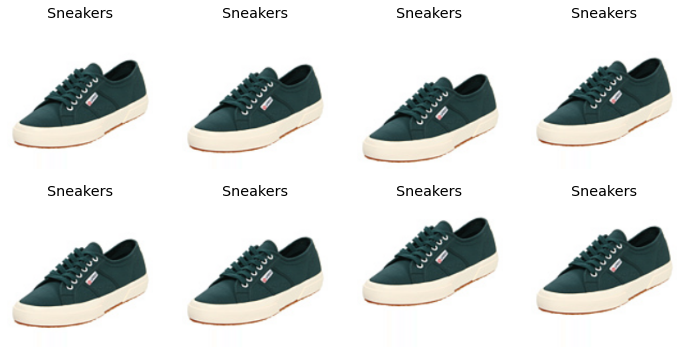

In [50]:
dblock.summary(df, bs=8, show_batch=True, unique=True)

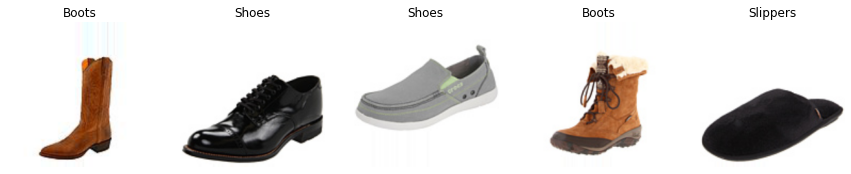

In [ ]:
dls1.show_batch(nrows=1, ncols=5) 


In [ ]:
dls1.train.get_idxs = lambda: Inf.ones


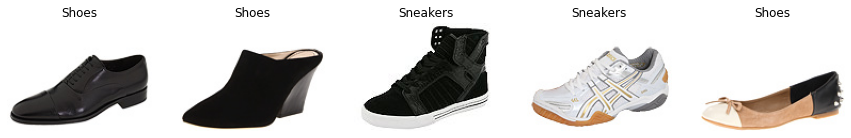

In [ ]:
dls.show_batch(nrows=1, ncols=5)

In [72]:
x,y = dls.train.one_batch()
x.shape

RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 3.95 GiB total capacity; 3.27 GiB already allocated; 28.19 MiB free; 3.31 GiB reserved in total by PyTorch)

In [71]:
xx = model_conv(x)

RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 3.95 GiB total capacity; 3.26 GiB already allocated; 48.19 MiB free; 3.29 GiB reserved in total by PyTorch)

In [ ]:
doc(setup_aug_tfms)

## CLEAN the database... create fast.ai type widgets

(1.2022644114040304e-06, 7.585775847473997e-07)

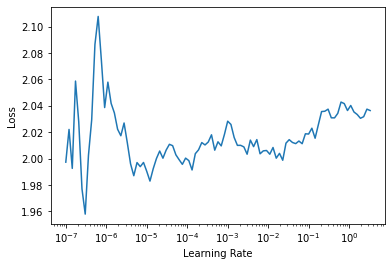

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep


(9.12010818865383e-08, 6.309573450380412e-07)

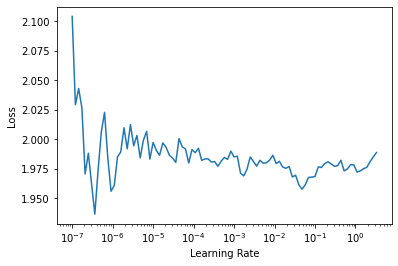

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep


In [ ]:
# choose learning rate around 1e-6
#lr = 10e-6
learn.fine_tune(2)

In [ ]:
doc(learn.freeze)

### learn.fine_tune(2, base_lr=3e-3)

lr_min,lr_steep = learn.lr_find()
learn.fine_tune(2, base_lr=3e-3)

In [ ]:
learn.fit_one_cycle(3, 3e-6)



learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

KeyboardInterrupt: 

IndexError: list index out of range

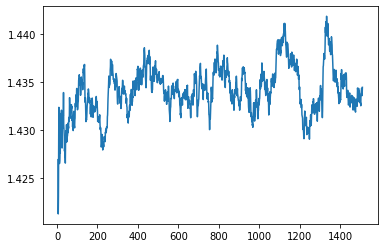

In [ ]:
learn.recorder.plot_loss()


# need to make a function to load data... 

In [ ]:
# from tensorflow import kerasratio=(0.75, 1.3333333333333333)
# from tensorflow.python.keras import backend as K

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten,Input
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications import imagenet_utils
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# import tensorflow as tf

In [ ]:

today = datetime.today()
today

datetime.datetime(2020, 12, 14, 22, 11, 44, 540704)

In [ ]:
# misnomer... don't actually have features yet...
# save the simple file
summary_file = f'./categories_with_features_{today:%b-%d-%Y}.pkl'
df.to_pickle(summary_file)

summary_file = f'./categories_with_features_{today:%b-%d-%Y}.json'
df.to_json(summary_file)



In [ ]:
# save the simple file
summary_file ='train_test_val_Jun-25-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Jun-25-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Jun-25-2020.json')

        

In [ ]:
df.path_and_file


0               [Shoes, Oxfords, Bostonian, 100627.72.jpg]
1              [Shoes, Oxfords, Bostonian, 100627.255.jpg]
2               [Shoes, Oxfords, Bostonian, 100657.72.jpg]
3              [Shoes, Oxfords, Bostonian, 100657.216.jpg]
4                 [Boots, Mid-Calf, Durango, 101026.3.jpg]
                               ...                        
50020            [Shoes, Heels, J. Renee, 8168300.128.jpg]
50021            [Shoes, Heels, J. Renee, 8168300.742.jpg]
50022          [Shoes, Heels, J. Renee, 8168300.57113.jpg]
50023         [Shoes, Heels, J. Renee, 8168300.384413.jpg]
50024    [Shoes, Sneakers and Athletic Shoes, Travis Ma...
Name: path_and_file, Length: 34278, dtype: object

In [ ]:
      
# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Feb-06-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Feb-05-2020.json')

        

# this fits the models

# Transfer learning with a pretrained ConvNet
Lets try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. Simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
We will not (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

General machine learning workflow:

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from os.path import isfile

In [ ]:
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.models import Model
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import os




def no_transfer_model(num_classes,input_shape):
    '''Implementation of vgg11 architecture '''

    X_in = Input(input_shape)
    X = Conv2D(64,3,activation='relu',padding='same')(X_in)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(128,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Flatten()(X)
    X = Dense(4096,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(4096,activation='relu')(X)
    X_out = Dense(num_classes,activation='softmax')(X)
    model = Model(input = X_in, output = X_out)

    return model



def model(model_name, num_classes, is_transfer, num_freeze_layer, weights_path,input_shape):

#     # vgg16_model
#     conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#     #conv_base_16.summary()


    #graph = tf.compat.v1.get_default_graph()

    if not is_transfer or model_name == 'simple':
        model = no_transfer_model(num_classes,input_shape)
        print('how did i get here')
        return model        
    
    
#     if model_name == 'vgg_16':
#         conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_16
#     elif model_name == 'vgg_19':
#         conv_base_19 = VGG19(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_19
#     elif model_name == 'mnNet_v2':
#         mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
#         model = mobileNet_v2
    if model_name == 'mnNet_v2':
        mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
        model = mobileNet_v2
    # final_model
    #global graph 
    #graph = tf.get_default_graph()
  
    print(model_name) 
    print(weights_path)
    print('------x-x-x-x-x-x---x-xx-x-x-x-xx------')   
    print(input_shape) 

    # freeze the given number of layers
    for layer in model.layers[:num_freeze_layer]:
        layer.trainable = False

    # Adding custom layers # maybe have a problem with the mobileNet_v2 output?
    m_out = model.output

    m_flatten = Flatten()(m_out)
    m_dense = Dense(1024,activation='relu')(m_flatten)
    m_drop = Dropout(0.5)(m_dense)
    m_dense = Dense(1024,activation='relu')(m_drop)
    pred_out = Dense(num_classes,activation='softmax')(m_dense)

    # final_model
    #with graph.as_default():
    #    final_model = Model(input=model.input,output=pred_out)
    final_model = Model(input=model.input,output=pred_out)

    print(final_model.summary())
    return final_model

# these functions set up the data

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from os.path import isdir,abspath,join
from os import listdir

data_path = './data/' # path of the data
train_path = './train'
test_path = './test'

def load_img_arr(p):
    return img_to_array(load_img(p))


def train_val_generator(
    batch_size, train_path,test_path,target_size=(136,136)):

    gen_tr = _train_generator()
    gen_val = _val_generator()

    sample = apply_to_images_in_subdirs(train_path,load_img_arr,num_per_cls = batch_size)
    sample = np.array(sample)
    gen_tr.fit(sample)
    gen_val.fit(sample)

    gen_tr = init_directory_generator(
        gen_tr,train_path,batch_size,target_size=target_size)

    gen_val = init_directory_generator(
        gen_val,test_path,batch_size,target_size=target_size)

    return gen_tr,gen_val


def _train_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=180,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )


def _val_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )

def apply_to_images_in_subdirs(parent_dir, func, num_per_cls=None, **kwargs):
    results = []
    for cls_dir_name in listdir(parent_dir):
        cls_dir = abspath(join(parent_dir, cls_dir_name))
        r = _apply_to_first_n_in_dir(func, cls_dir, num_per_cls, **kwargs)
        results += r
    return results


def _apply_to_first_n_in_dir(func, dir_, num_per_cls, **kwargs):
    if not isdir(dir_):
        return []
    results = []
    for path in listdir(dir_)[:num_per_cls]:
        abspath_ = abspath(join(dir_, path))
        result = func(abspath_, **kwargs)
        results.append(result)
    return results




def init_directory_generator(
    gen, dir_,batch_size, target_size=(136,136),
    class_mode='categorical',shuffle=True):

    return gen.flow_from_directory(
        dir_,
        class_mode = class_mode,
        batch_size = batch_size,
        target_size = target_size,
        shuffle = shuffle
    )

ModuleNotFoundError: No module named 'keras'

# this fits the models

In [ ]:
model_name ='mnNet_v2' #'vgg_16','vgg_19','mnNet_v2','resnet_152','simple'])
is_transfer=True
num_freeze_layer=5
num_classes=4
weights_path='mnNet_v2_weights_tf.h5'
input_shape=(224,224,3)#(img_width,img_height,img_channel)')
batch_size=32
train_path='./train'
test_path='./test'


# model for traning
tr_model = model(model_name,num_classes,is_transfer, num_freeze_layer,weights_path,input_shape)

# train and test generator
train_gen, val_gen = train_val_generator(batch_size,train_path,test_path)

mnNet_v2
mnNet_v2_weights_tf.h5
------x-x-x-x-x-x---x-xx-x-x-x-xx------
(224, 224, 3)


TypeError: ('Keyword argument not understood:', 'input')